In [1]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

### Data Preprocessing

In [2]:
# udata = pd.read_csv('ml-100k/u.data', sep='\t', names=['userid', 'itemid', 'rating', 'timestamp'])
# udata.tail()
# hidden_dim=100

In [3]:
udata = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['userid', 'itemid', 'rating', 'timestamp'])
udata.tail()
hidden_dim=1200
udata = udata[udata.rating >=5]

/home/ardiya/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [4]:
map_uid_index = {uid:idx for idx, uid in enumerate(udata['userid'].unique())}
map_iid_index = {iid:idx for idx, iid in enumerate(udata['itemid'].unique())}

total_user = len(map_uid_index.items())
total_item = len(map_iid_index.items())

list_users = range(total_user)

print("There are %d users and %d items" % (total_user, total_item))

There are 6014 users and 3232 items


#### Split the dataset into 10% test set, the rest is splitted to 20% validation set and 10% train set

In [5]:
# m = np.mean(udata.rating)
# s = np.std(udata.rating)
# udata.rating -=  m
# udata.rating /= s
# udata

In [6]:
# normalize = lambda x:(x-3)/2
# normalize = lambda x:x/5
# normalize = lambda x: x
normalize = lambda x: 1. if x == 5 else .5 if x == 4 else 0

from sklearn import cross_validation
udata_train_validation, udata_test = cross_validation.train_test_split(udata, test_size=0.2)
udata_train, udata_validation = cross_validation.train_test_split(udata_train_validation, test_size=0.1)

train_matrix = np.zeros([total_user, total_item], dtype=float)
validation_matrix = np.zeros([total_user, total_item], dtype=float)
test_matrix = np.zeros([total_user, total_item], dtype=float)
full_matrix = np.zeros([total_user, total_item], dtype=float)

data_map = [(train_matrix, udata_train), (validation_matrix, udata_validation),
            (test_matrix, udata_test), (full_matrix, udata)]

for imatrix, idata in data_map:
    for line in idata.itertuples():
        imatrix[map_uid_index[line[1]],
                     map_iid_index[line[2]]] = normalize(line[3])

print(train_matrix.shape)
print(validation_matrix.shape)
print(test_matrix.shape)
print(full_matrix.shape)

(6014, 3232)
(6014, 3232)
(6014, 3232)
(6014, 3232)


In [7]:
def five_star_item(list2d):
    ret = list()
    for i in range(len(list2d)):
        list1d = list2d[i]
        ret.append([idx for idx, val in enumerate(list1d) if val == 1])
    return ret
m = five_star_item(full_matrix)
print(m[1])

[0, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [8]:
# Randomly selecting item for each batch
def get_batch(X, X_, size):
    a = np.random.choice(len(X), size, replace=False)
    return X[a], X_[a], a

### Evaluation Metrics

In [9]:
# Root Mean Square Error for validation test
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    r = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(prediction, ground_truth))))
    return sess.run(r)

In [10]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

#     if not actual:
#         return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [11]:
print(apk(range(1,6),[6,4,7,1,2], 2)) #.25
print(apk(range(1,6),[1,1,1,1,1], 5)) #0.2
print(mapk([[1,3,4],[1,2,4],[1,3]],
                   [range(1,6),range(1,6),range(1,6)], 3)) #0.685185185185185

0.25
0.2
0.685185185185


In [23]:
start_time = time.time()

#output is the train matrix
data_x_ = train_matrix
#add noise to the input
data_x = data_x_ + np.random.normal(0, 0.1, (len(data_x_), len(data_x_[0])))

#Setup Hyper Parameters
epoch = 1000
input_dim = len(data_x[0])
#hidden_dim = 100
batch_size = 512

#variable for plot
plt_x = list()
plt_y1 = list()
plt_y2 = list()

sess = tf.Session()

#setup placeholder and variables
x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim], name='x')
x_ = tf.placeholder(dtype=tf.float32, shape=[None, input_dim], name='x_')

enc_w = tf.Variable(tf.truncated_normal([input_dim, hidden_dim], dtype=tf.float32))
enc_b = tf.Variable(tf.truncated_normal([hidden_dim], dtype=tf.float32))
dec_w = tf.transpose(enc_w)
dec_b = tf.Variable(tf.truncated_normal([input_dim], dtype=tf.float32))

#setup network
encoded = tf.nn.relu(tf.matmul(x, enc_w) + enc_b, name='encoded')
decoded = tf.nn.relu(tf.matmul(encoded, dec_w) + dec_b, name='decoded')

#setup loss
loss = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(x_, decoded))))  
loss += 5e-5 * (tf.nn.l2_loss(enc_b)+ tf.nn.l2_loss(dec_b)+ tf.nn.l2_loss(enc_w))

#optimizer
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(.01, global_step, 10000, 0.86, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess.run(tf.initialize_all_variables())

print("-"*49)
print("|   ID|%20s|%20s|"%("Train RMSE", "Validation RMSE"))
print("-"*49)
for i in range(epoch):
    b_x, b_x_, users = get_batch(data_x, data_x_, batch_size)
    #update using optimizer
    sess.run(optimizer, feed_dict={x:b_x, x_: b_x_})
    #print loss
    if (i+1) % 100 == 0:
        #training loss
        l = sess.run(loss, feed_dict={x:data_x, x_: data_x_})
        
        #prediction
        pred = sess.run(decoded, feed_dict={x:data_x_, x_: data_x_})
        val_rmse = rmse(pred, validation_matrix)
        print("|%5d|%20f|%20f|"%(i+1, l, val_rmse))
        
        #plot
        plt_x.append(i+1)
        plt_y1.append(l)
        plt_y2.append(val_rmse)
        

print("--- Training time: %s seconds ---" % (time.time() - start_time))
print("TEST RMSE: ", rmse(pred, test_matrix))

pred = sess.run(decoded, feed_dict={x:data_x_, x_: data_x_})
pred = pred * (train_matrix == 0) # remove watched items from predictions
pred = np.argsort(pred)

for n in range(1, 11):
    sr = mapk(actual=m, predicted=list(pred[:,-n:]), k=n)
    print("MAP@", n, ":", sr)
    #print(sr)

-------------------------------------------------
|   ID|          Train RMSE|     Validation RMSE|
-------------------------------------------------
|  100|           39.931038|            1.432937|
|  200|           16.115826|            1.057468|
|  300|            6.476654|            0.994073|
|  400|            2.721665|            0.988922|
|  500|            1.236815|            0.983032|
|  600|            0.617621|            0.984814|
|  700|            0.341492|            0.984331|
|  800|            0.210893|            0.986308|
|  900|            0.145748|            0.985183|
| 1000|            0.112052|            0.984707|
--- Training time: 29.86239242553711 seconds ---
TEST RMSE:  0.984737
0.0473894246758
0.0330894579315
0.0255237778517
0.0206289491187
0.0178885378561
0.0158343494808
0.0136388534463
0.0122371493631
0.0110312240805
0.0103714290406


In [13]:
pred

array([[   0, 2147, 2148, ...,  169,  225,  181],
       [   0, 2148, 2149, ...,  232,  484,  534],
       [   0, 2149, 2150, ...,  534,  260, 1032],
       ..., 
       [   0, 2148, 2149, ...,  534,  540,  260],
       [   0, 2147, 2148, ..., 1074,  764, 1263],
       [   0, 2147, 2148, ...,  584, 1400,  437]])

### Denoising AutoEncoder with normal distribution

In [24]:
start_time = time.time()

#output is the train matrix
data_x_ = train_matrix
#add noise to the input
data_x = data_x_ + np.random.normal(0, 0.2, (len(data_x_), len(data_x_[0])))

#Setup Hyper Parameters
epoch = 2000
input_dim = len(data_x[0])
#hidden_dim = 100
batch_size = 512

#variable for plot
plt_x = list()
plt_y1 = list()
plt_y2 = list()

sess = tf.Session()

#setup placeholder and variables
x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim], name='x')
x_ = tf.placeholder(dtype=tf.float32, shape=[None, input_dim], name='x_')
train_inputs = tf.placeholder(tf.int32, shape=[None], name='train_inputs')

enc_w = tf.Variable(tf.truncated_normal([input_dim, hidden_dim], dtype=tf.float32))
enc_b = tf.Variable(tf.truncated_normal([hidden_dim], dtype=tf.float32))
#dec_w = tf.transpose(enc_w)
dec_w = tf.Variable(tf.truncated_normal([hidden_dim, input_dim], dtype=tf.float32))
dec_b = tf.Variable(tf.truncated_normal([input_dim], dtype=tf.float32))
embeddings = tf.Variable(tf.random_uniform([input_dim, hidden_dim], -.5, .5))

#setup network
encoded = tf.nn.relu(tf.matmul(x, enc_w) + enc_b, name='encoded')
embed = tf.nn.embedding_lookup(embeddings, train_inputs, name='embed')
enc_embed = tf.add(encoded, embed)
decoded = tf.nn.relu(tf.matmul(enc_embed, dec_w) + dec_b, name='decoded')

#setup loss
loss = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(x_, decoded))))  
loss += 5e-5 * (
        tf.nn.l2_loss(embeddings)
        + tf.nn.l2_loss(enc_b)
        + tf.nn.l2_loss(dec_b)
        + tf.nn.l2_loss(enc_w)
        + tf.nn.l2_loss(dec_w)
)

#optimizer
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(.01, global_step, 10000, 0.86, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess.run(tf.initialize_all_variables())

print("-"*49)
print("|   ID|%20s|%20s|"%("Train RMSE", "Validation RMSE"))
print("-"*49)
for i in range(epoch):
    b_x, b_x_, users = get_batch(data_x, data_x_, batch_size)
    #update using optimizer
    sess.run(optimizer, feed_dict={x:b_x, x_: b_x_, train_inputs:users})
    #print loss
    if (i+1) % 100 == 0:
        #training loss
        l = sess.run(loss, feed_dict={x:data_x, x_: data_x_, train_inputs:list_users})
        
        #prediction
        pred = sess.run(decoded, feed_dict={x:data_x_, train_inputs:list_users})
        val_rmse = rmse(pred, validation_matrix)
        print("|%5d|%20f|%20f|"%(i+1, l, val_rmse))
        
        #plot
        plt_x.append(i+1)
        plt_y1.append(l)
        plt_y2.append(val_rmse)
        

print("--- Training time: %s seconds ---" % (time.time() - start_time))
print("TEST RMSE: ", rmse(pred, test_matrix))

pred = sess.run(decoded, feed_dict={x:data_x_, train_inputs:list_users})
pred = pred * (train_matrix == 0) # remove watched items from predictions
pred = np.argsort(pred)

for n in range(1, 11):
    sr = mapk(actual=m, predicted=list(pred[:,-n:]), k=n)
    print("MAP@", n, ":", sr)
    #print(sr)

-------------------------------------------------
|   ID|          Train RMSE|     Validation RMSE|
-------------------------------------------------
|  100|           73.484512|            1.010365|
|  200|           29.447542|            1.000000|
|  300|           11.851405|            1.000000|
|  400|            5.225925|            1.000000|
|  500|            2.543041|            0.999939|
|  600|            1.334266|            0.999838|
|  700|            0.746467|            0.999522|
|  800|            0.445319|            0.999893|
|  900|            0.287127|            0.999504|
| 1000|            0.203861|            0.997496|
| 1100|            0.153237|            0.997192|
| 1200|            0.126613|            0.995846|
| 1300|            0.110805|            0.994437|
| 1400|            0.101539|            0.992421|
| 1500|            0.096193|            0.992462|
| 1600|            0.092927|            0.990431|
| 1700|            0.091095|            0.990898|


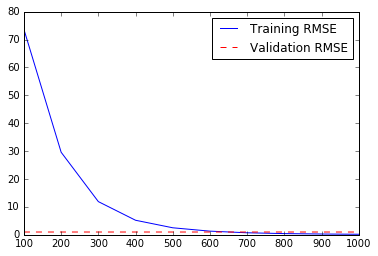

In [15]:
plt.plot(plt_x, plt_y1, label='Training RMSE')
plt.plot(plt_x, plt_y2, linestyle='--', color='r', label='Validation RMSE')
plt.legend()
plt.show()

In [16]:
def success_rate(pred, true):
    cnt = 0
    for i in range(pred.shape[0]):
        t = np.where(true[i] == 1) # true set
        ary = np.intersect1d(pred[i], t)
        if ary.size > 0:
            cnt += 1
    return cnt * 100 / pred.shape[0]

In [17]:
pred = sess.run(decoded, feed_dict={x:data_x_, train_inputs:list_users})
pred = pred * (train_matrix == 0) # remove watched items from predictions
pred = np.argsort(pred)

for n in range(1, 11):
    sr = success_rate(pred[:, -n:], test_matrix)
    print("Success Rate at {:d}: {:f}".format(n, sr))

Success Rate at 1: 1.596275
Success Rate at 2: 3.259062
Success Rate at 3: 4.772198
Success Rate at 4: 6.235451
Success Rate at 5: 7.515796
Success Rate at 6: 8.513469
Success Rate at 7: 9.561024
Success Rate at 8: 10.325906
Success Rate at 9: 11.057532
Success Rate at 10: 11.390090


In [18]:
pred = sess.run(decoded, feed_dict={x:data_x_, train_inputs:list_users})
pred = pred * (train_matrix == 0) # remove watched items from predictions
pred = np.argsort(pred)

for n in range(1, 11):
    sr = success_rate(pred[:, -n:], full_matrix)
    print("Success Rate at {:d}: {:f}".format(n, sr))


Success Rate at 1: 2.311274
Success Rate at 2: 4.506152
Success Rate at 3: 6.551380
Success Rate at 4: 8.496841
Success Rate at 5: 10.192883
Success Rate at 6: 11.606252
Success Rate at 7: 13.086132
Success Rate at 8: 14.050549
Success Rate at 9: 15.114732
Success Rate at 10: 15.763219


In [19]:
pred = sess.run(decoded, feed_dict={x:data_x_, train_inputs:list_users})
pred = np.argsort(pred)
actual = np.argsort(train_matrix)

for n in range(1, 11):
    sr = mapk(actual=list(actual[:,-n:]), predicted=list(pred[:,-n:]), k=n)
    print("MAP@", n, ":", sr)

MAP@ 1 : 0.0400731626206
MAP@ 2 : 0.0310525440639
MAP@ 3 : 0.0316021874885
MAP@ 4 : 0.030002909877
MAP@ 5 : 0.0311351291431
MAP@ 6 : 0.0353924176921
MAP@ 7 : 0.0409458994772
MAP@ 8 : 0.048742220533
MAP@ 9 : 0.057609705807
MAP@ 10 : 0.0681741676828


In [20]:
full_matrix[:10,:10]

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.]])

In [21]:
asd = sess.run(decoded, feed_dict={x:data_x_, train_inputs:list_users})
asd[:10,:10]
res = np.argsort(asd)

for i in range(10):
    idx = np.random.randint(total_user)
    print("Pred @", idx, ":", res[idx,-10:])
    print("5*   @", idx, ":", m[idx])
    

Pred @ 2155 : [ 751 2357  764  530  479  813  370  383  106  938]
5*   @ 2155 : [8, 29, 57, 66, 74, 127, 142, 270, 279, 286, 386, 424, 561, 599, 696, 697, 736, 754, 847, 849, 872, 879, 938, 977, 1018, 1038, 1040, 1327, 1338, 1347, 1388, 1400, 1663]
Pred @ 5787 : [706 488 658 938 383 892 200  38  35 281]
5*   @ 5787 : [0, 3, 4, 5, 6, 7, 8, 11, 14, 15, 19, 21, 22, 24, 28, 30, 35, 36, 37, 38, 41, 42, 43, 45, 47, 48, 51, 52, 54, 57, 58, 60, 62, 74, 78, 87, 89, 91, 93, 99, 103, 105, 108, 110, 115, 116, 117, 130, 138, 148, 151, 155, 157, 159, 164, 167, 170, 172, 174, 185, 197, 198, 206, 208, 209, 215, 216, 217, 219, 229, 233, 235, 243, 247, 249, 253, 257, 258, 260, 261, 275, 281, 284, 288, 303, 315, 321, 335, 348, 349, 364, 370, 396, 401, 403, 407, 414, 424, 437, 439, 452, 460, 461, 465, 481, 485, 493, 513, 518, 519, 523, 529, 530, 542, 543, 544, 547, 549, 552, 553, 557, 561, 578, 579, 585, 598, 602, 607, 620, 621, 624, 627, 630, 631, 633, 647, 655, 656, 657, 658, 663, 697, 705, 712, 713, 72